TODO HACKDAVIS DAY 2 (INORDER)
- Figure out the outliers
  - Boxplots are funky
  - Use historams?
- Normalise the data
  - Histograms like the from the lecture (Three colorful shifted histograms)
- Clean up code according to ".h" file in google docs

# Data Cleaning


## Import Data

In [169]:

import csv # lib for reading csvs
import pandas as pd #for processing data into a DataFrame.
import matplotlib.pyplot as plt #for plotting.
%pip install tensorflow

import tensorflow as tf

import seaborn as sns
#dont care about these for now.
import numpy as np #for numerical processing.
from sklearn.linear_model import LogisticRegression #a type of classification model.
from sklearn.model_selection import train_test_split #function useful to split data into (train|test) splits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler #scaling values.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score


Note: you may need to restart the kernel to use updated packages.


In [234]:
# Load the data
solar_data = pd.read_csv("solar_weather_data.csv")

#drop the first 3 columns
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)

# Convert time column from epoch ms to hour in day (ie 16 or 5) with time zone pacific
solar_data['time'] = pd.to_datetime(solar_data['time'], unit='ms')
solar_data['time'] = solar_data['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
solar_data['time'] = solar_data['time'].dt.hour

#print(type(solar_data))
pd.set_option('display.width', 1000)
print(solar_data.head(10))
print("\n")

   time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
0    18        28.1  46.6     71.63     0.0           0          0.2              62           4.9  55.6        1          17
1    19        15.8  45.7     76.61     0.0           0          0.1              14          -6.3  52.8        0           0
2    20         8.7  47.8     85.89     0.0           0          0.1               0         -17.9  51.9        0           0
3    21         8.7  45.9     87.05     0.0           0          0.1               0         -29.8  49.6        0           0
4    22        15.8  46.6     90.75     0.0           0          0.1               0         -41.7  49.2        0           0
5    23        16.5  44.7     85.73     0.0           0          0.1               0         -53.1  48.8        0           0
6     0         8.7  44.7     91.88     0.0           0          0.1               0         -63.2  46.9        0     

In [218]:
## Remove rows which where affected by database outages
# Remove rows where 0 whProduced and sunelevation > -1, the sun cant be up and not producing power
solar_data = solar_data.drop(solar_data[(solar_data['sunelevation'] > -1) & (solar_data['whProduced'] < 5)].index)
# Remove rows with whProduced > 5000, these are likely outliers
solar_data = solar_data.drop(solar_data[solar_data['whProduced'] > 5000].index)

In [219]:
# Drop infinite values and NaN
solar_data = solar_data.replace([np.inf, -np.inf], np.nan)
solar_data = solar_data.dropna()

In [230]:
X = solar_data[['time', 'cloudcover', 'dew', 'humidity', 'precip', 'precipprob', 'solarenergy', 'solarradiation', 'sunelevation', 'temp', 'uvindex']]
# X = solar_data[['humidity', 'solarradiation', 'sunelevation', 'temp']]
y = solar_data['whProduced']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = solar_data.quantile(0.25)
Q3 = solar_data.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define a multiplier for the IQR to determine the outlier threshold
threshold_multiplier = 1.5  # You can adjust this multiplier based on your dataset and requirements

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - threshold_multiplier * IQR
upper_bound = Q3 + threshold_multiplier * IQR

# Find indices of outliers
outlier_indices = ((solar_data < lower_bound) | (solar_data > upper_bound)).any(axis=1)

# Remove outliers from the training set and corresponding target variable
solar_data = solar_data[~outlier_indices]

# Print the number of outliers removed
num_outliers_removed = np.sum(outlier_indices)
print("Number of outliers removed:", num_outliers_removed)

Number of outliers removed: 0


In [ ]:
# ADD NORMILIZATION HERE

In [231]:
# print first 20 rows
print(solar_data.head(40))

     time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
30      0         8.5  42.6     88.09     0.0           0          0.0               0         -62.9  46.0        0           0
31      1         8.7  40.7     86.40     0.0           0          0.0               0         -69.2  44.5        0           0
32      2         0.0  40.4     89.43     0.0           0          0.0               0         -68.1  43.3        0           0
33      3         0.0  38.9     91.84     0.0           0          0.0               0         -60.4  41.1        0           0
34      4        90.6  40.2     95.98     0.0           0          0.0               0         -49.8  41.2        0           0
35      5        97.8  39.7     92.15     0.0           0          0.0               0         -38.2  41.8        0           0
36      6        97.8  42.9     91.69     0.0           0          0.0               0         -26.3  45

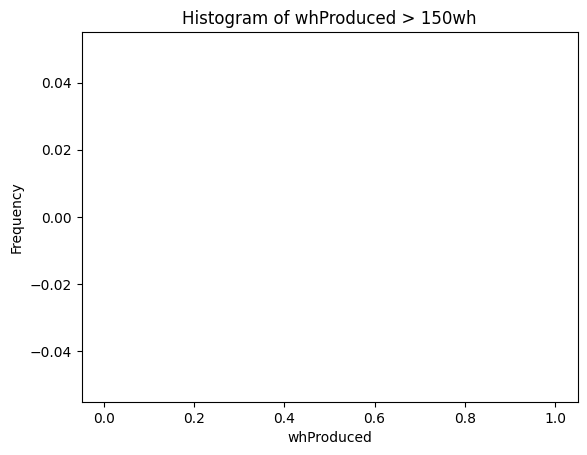

In [232]:
filtered_data = solar_data[solar_data['whProduced'] > 150]
plt.hist(filtered_data['whProduced'], bins=20)
plt.xlabel('whProduced')
plt.ylabel('Frequency')
plt.title('Histogram of whProduced > 150wh')
plt.show()

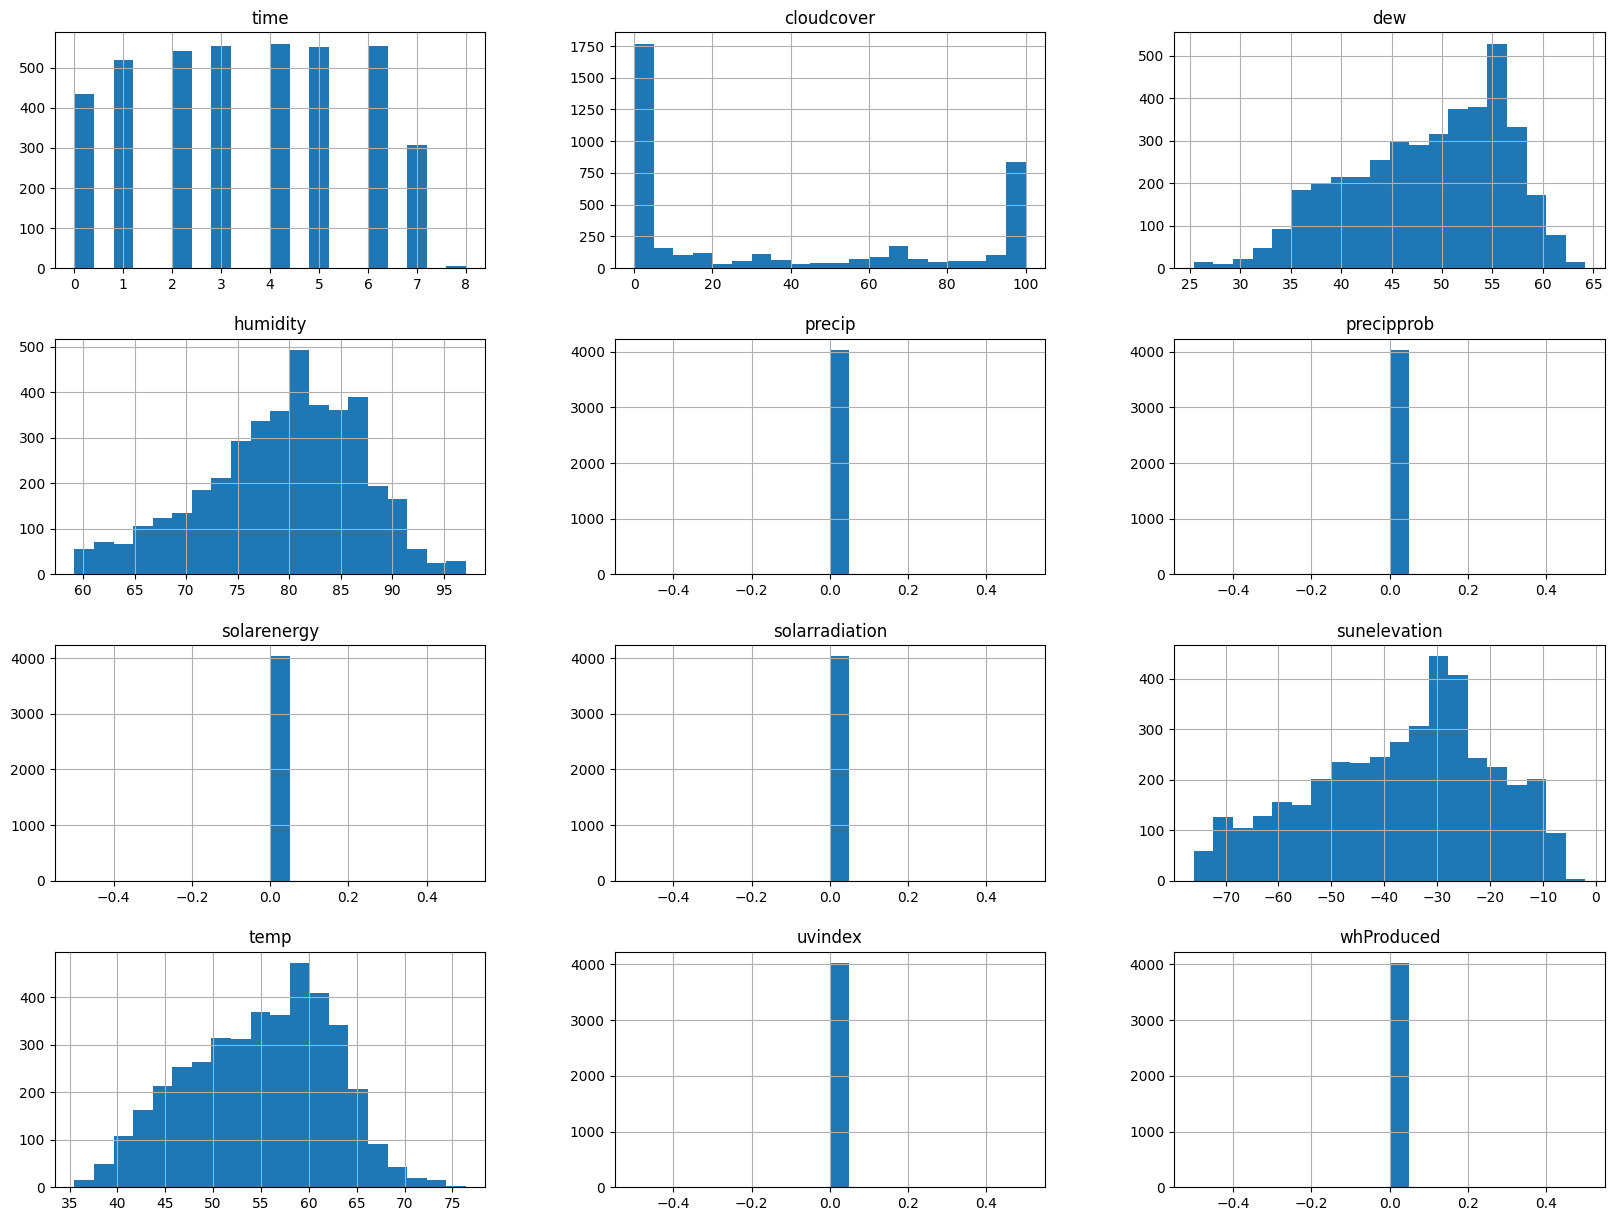

In [233]:
# Plot histograms for each of the features
solar_data.hist(bins=20, figsize=(20,15))
plt.show()

## Correlation

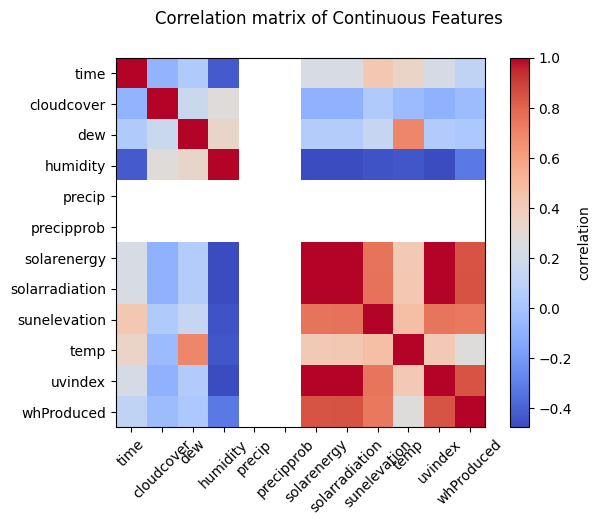

In [192]:
corrmat = solar_data.corr()
plt.imshow(corrmat, cmap='coolwarm')
plt.colorbar(label = "correlation")
plt.xticks(range(len(corrmat)), corrmat.columns, rotation=45)
plt.yticks(range(len(corrmat)), corrmat.columns)
plt.suptitle("Correlation matrix of Continuous Features")
plt.show()

In [194]:
# Drop uncorrelated features
solar_data = solar_data.drop(columns=['time', 'cloudcover', 'dew', 'precip', 'precipprob'])

# Drop all but one of the highly correlated features
solar_data = solar_data.drop(columns=['solarenergy', 'uvindex'])

In [195]:
# print first 20 rows
print(solar_data.head(20))

    humidity  solarradiation  sunelevation  temp  whProduced
0      71.63              62           4.9  55.6          17
1      76.61              14          -6.3  52.8           0
2      85.89               0         -17.9  51.9           0
3      87.05               0         -29.8  49.6           0
4      90.75               0         -41.7  49.2           0
5      85.73               0         -53.1  48.8           0
6      91.88               0         -63.2  46.9           0
7      90.72               0         -69.5  45.4           0
8      90.86               0         -68.3  44.9           0
9      89.44               0         -60.6  43.6           0
10     90.51               0         -50.0  43.0           0
11     86.51               0         -38.4  42.8           0
12     90.04               0         -26.4  42.2           0
13     89.49               0         -14.6  42.0           0
14     92.63              26          -3.1  41.2          49
15     91.68            

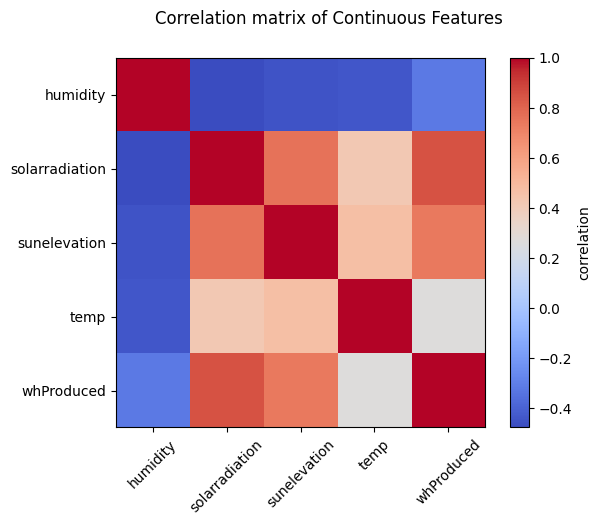

In [196]:
corrmat = solar_data.corr()
plt.imshow(corrmat, cmap='coolwarm')
plt.colorbar(label = "correlation")
plt.xticks(range(len(corrmat)), corrmat.columns, rotation=45)
plt.yticks(range(len(corrmat)), corrmat.columns)
plt.suptitle("Correlation matrix of Continuous Features")
plt.show()

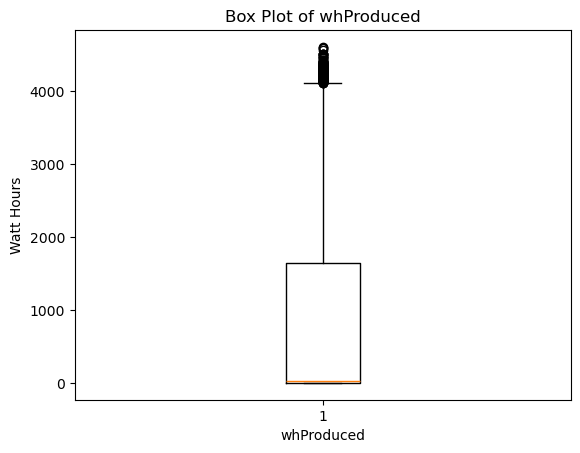

In [182]:
plt.boxplot(solar_data['whProduced'])
plt.xlabel('whProduced')
plt.ylabel('Watt Hours')
plt.title('Box Plot of whProduced')
plt.show()


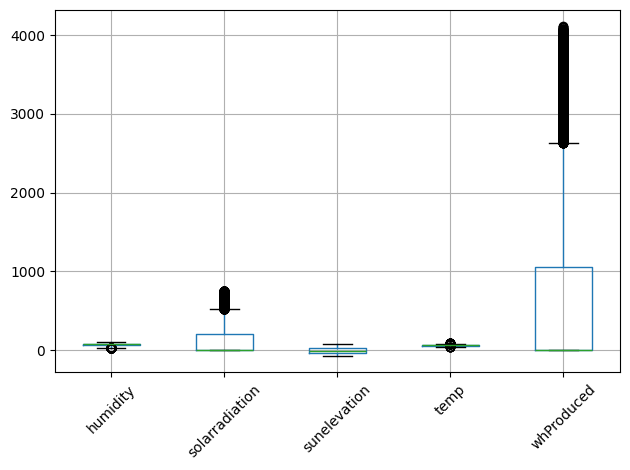

In [197]:
solar_data.boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Why are the box plots so wild?!?

# Linear Regression

MSE: 261796.18730092875
R^2: 0.8485812347524049


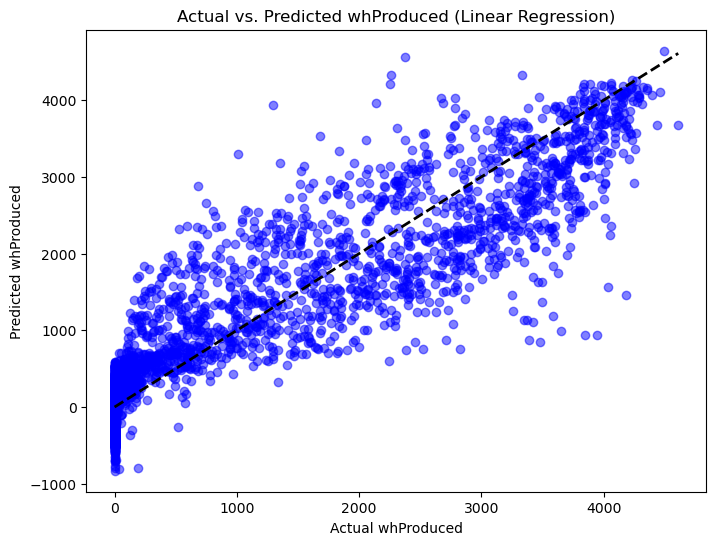

Bias: 1.6122456077304006
Variance: 1482256.664808898


In [163]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2:", r2)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Linear Regression)')
plt.show()

mean_predicted = np.mean(y_pred)
mean_true = np.mean(y_test)

# Bias
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2) # 1.6122456077304006
# bias = mean_squared_error(y_test, y_pred)

# Variance
variance = np.var(y_pred)
# variance = np.mean((np.mean(y_test) - y_test) ** 2) # 1728954.7096282812

print("Bias:", bias)
print("Variance:", variance)

In [164]:
# predict on a row
print(model.predict(X_test.iloc[[16]]))

[-403.51828743]


Mean Squared Error: 107943414.14913091
R-squared: -61.432759833447776


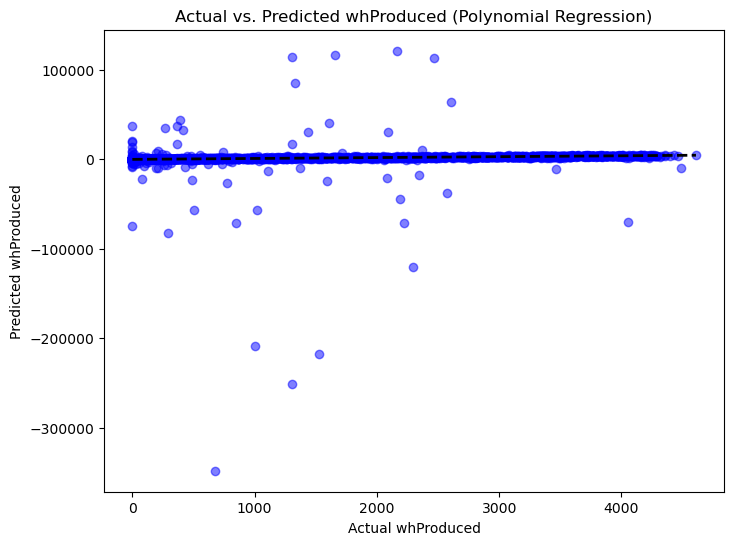

Bias: 1.6122456077304006
Variance: 108282099.45413786


In [165]:
degree = 5  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()
# bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)

# Variance
# variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Bias:", bias)
print("Variance:", variance)

Mean Squared Error: 17049484.352634113
R-squared: -8.861151514084305


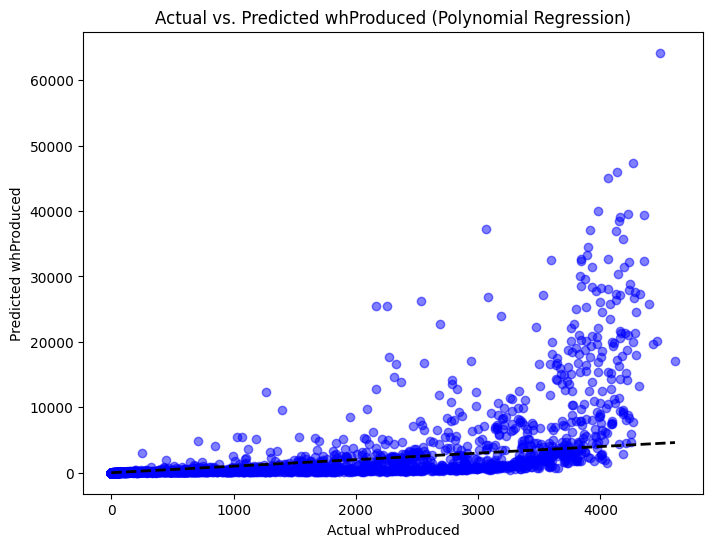

Bias: 1.6122456077304006
Variance: 22467597.87311977


In [166]:
degree = 2  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
#model = LinearRegression()
#model.fit(X_train_poly, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test_poly)

# Transform the target variable
y_train_transformed = np.log1p(y_train)

# Train the model on the transformed data
model.fit(X_train, y_train_transformed)

# Predict the transformed values
y_pred_transformed = model.predict(X_test)

# Apply the inverse transformation to get the final predictions
y_pred = np.expm1(y_pred_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()

# Bias
#bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)
print("Bias:", bias)

# Variance
#variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Variance:", variance)

In [167]:
# predict on a row
#print(model.predict(X_train_poly[[18]]))
print(model.predict(solar_data.iloc[[16]].drop(columns=['whProduced'])))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- cloudcover
- dew
- precip
- precipprob
- solarenergy
- ...


Epoch 1/100
383/383 [==============================] - 0s 736us/step - loss: 971257.2500 - val_loss: 253053.1250
Epoch 2/100
383/383 [==============================] - 0s 637us/step - loss: 200364.1094 - val_loss: 166906.5312
Epoch 3/100
383/383 [==============================] - 0s 638us/step - loss: 136622.8281 - val_loss: 119957.0703
Epoch 4/100
383/383 [==============================] - 0s 635us/step - loss: 110844.4375 - val_loss: 106748.4297
Epoch 5/100
383/383 [==============================] - 0s 631us/step - loss: 102812.2812 - val_loss: 101220.1562
Epoch 6/100
383/383 [==============================] - 0s 653us/step - loss: 99875.8438 - val_loss: 98594.1953
Epoch 7/100
383/383 [==============================] - 0s 640us/step - loss: 97589.5156 - val_loss: 98415.6797
Epoch 8/100
383/383 [==============================] - 0s 639us/step - loss: 95911.5703 - val_loss: 95514.4297
Epoch 9/100
383/383 [==============================] - 0s 626us/step - loss: 94930.1953 - val_loss: 93

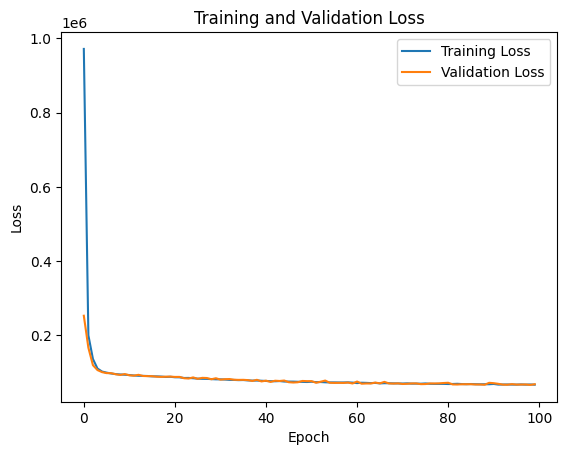

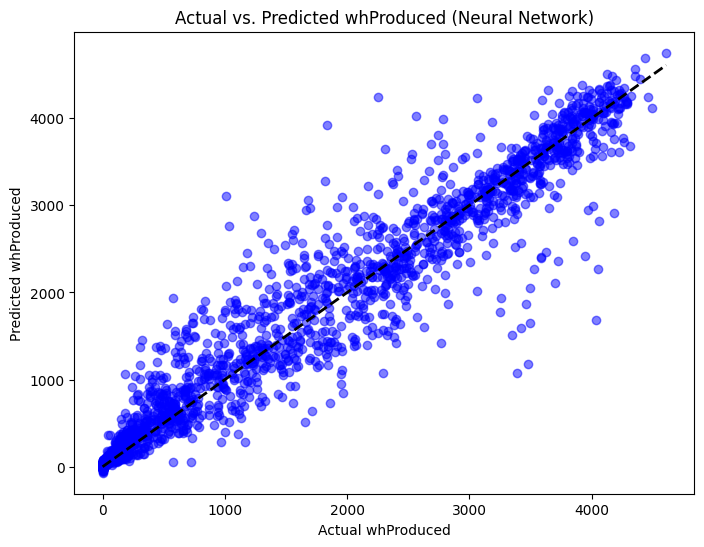

Bias: 1728956.3218738888
Variance: 1721318.0


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Neural Network)')
plt.show()

bias = np.mean((mean_predicted - y_test) ** 2)

# Variance
variance = np.mean((y_pred - mean_predicted) ** 2)
print("Bias:", bias)
print("Variance:", variance)

# Transformation of skewed data

import numpy as np
import matplotlib.pyplot as plt

skewed_data=y


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 8.435766192720509] is not finite

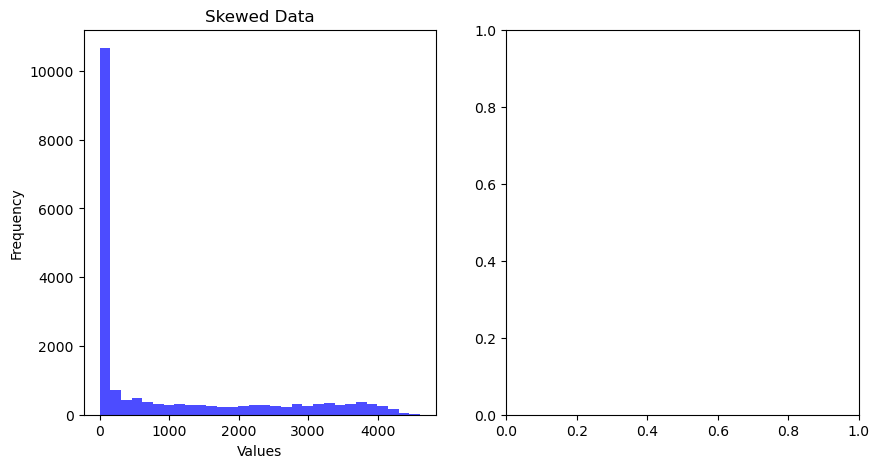

In [ ]:
# Plot the histogram of skewed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(skewed_data, bins=30, color='blue', alpha=0.7)
plt.title('Skewed Data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Apply transformations
log_transformed = np.log(skewed_data)
sqrt_transformed = np.sqrt(skewed_data)
inverse_transformed = 1 / skewed_data
exp_transformed = np.exp(skewed_data)

# Plot histograms of transformed data
plt.subplot(1, 2, 2)
plt.hist(log_transformed, bins=30, color='green', alpha=0.7, label='Log Transformation')
plt.hist(sqrt_transformed, bins=30, color='red', alpha=0.7, label='Square Root Transformation')
plt.hist(inverse_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')
plt.hist(exp_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')

plt.title('Transformed Data')
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

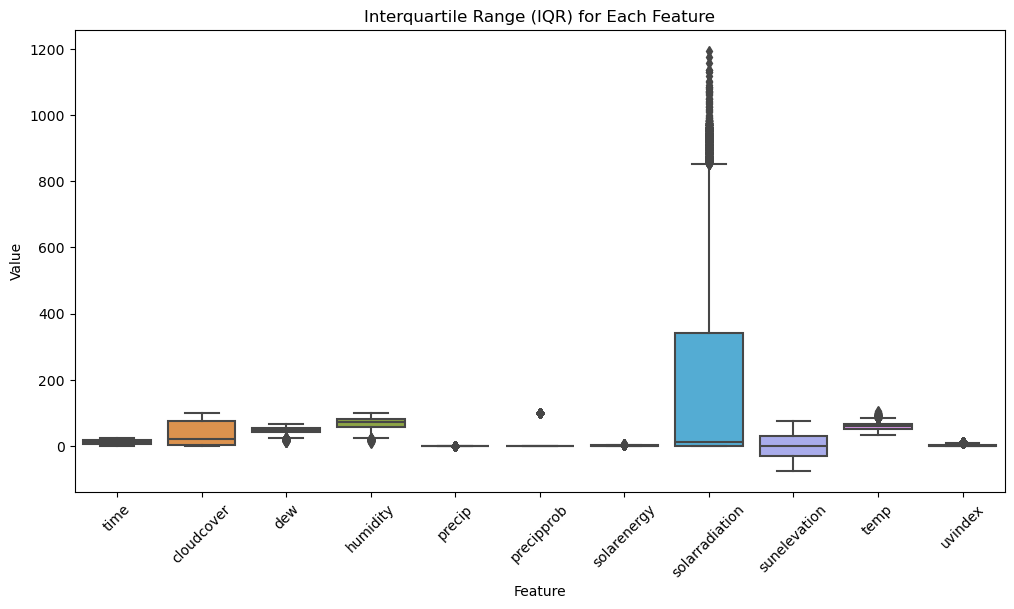

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.title('Interquartile Range (IQR) for Each Feature')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()